For this step we're going to use Keras. This will also start up your GPU if you're using one, which can take up to **10 seconds**.

In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
print keras.__version__
print tf.__version__

Using TensorFlow backend.


2.2.4
1.15.0


Now let's load the data, and convert the labels to categories. So `0` becomes `[1, 0]` and `1` becomes `[0, 1]`. This makes it easy to add more classes later (like "angry", "sad", etc.) and interpret the predictions as probabilities. We do this after loading the file instead of before saving to avoid having a big labels file on disk.

Then we shuffle all the examples to make sure we don't hold out only one class for validation. And finally we count up how many instances there are of each class to make ensure that we put more emphasis on the rarer ones during training.

In [2]:
# load the data
X = np.load('X.npy')
y = np.load('y.npy')

# convert classes to vector
nb_classes = 2
y = np_utils.to_categorical(y, nb_classes).astype(np.float32)

# shuffle all the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

print X.dtype, X.min(), X.max(), X.shape
print y.dtype, y.min(), y.max(), y.shape

float32 0.0 1.0 (38348, 32, 32, 1)
float32 0.0 1.0 (38348, 2)


Now we set up our network. It is based on the Keras `mnist_cnn.py` example, following in the footsteps of VGG net by using small 3x3 convolutions with max pooling, and a final stage of multiple dense layers.

In [3]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
____________________

Now that our data and model is ready, we can train the model on the data for a few epochs, holding out 10% of the data for validating the accuracy. This should take about **30 seconds**.

In [4]:
validation_split = 0.10
history = model.fit(X, y, batch_size=128, class_weight=class_weight, epochs=50, verbose=1, validation_split=validation_split)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 34513 samples, validate on 3835 samples
Epoch 1/50





34513/34513 [==============================] - 24s 695us/step - loss: 0.3773 - acc: 0.8407 - val_loss: 0.2740 - val_acc: 0.8892
Epoch 2/50
34513/34513 [==============================] - 21s 605us/step - loss: 0.2866 - acc: 0.8830 - val_loss: 0.2417 - val_acc: 0.9022
Epoch 3/50
34513/34513 [==============================] - 22s 627us/step - loss: 0.2626 - acc: 0.8951 - val_loss: 0.2195 - val_acc: 0.9098
Epoch 4/50
34513/34513 [==============================] - 22s 650us/step - loss: 0.2461 - acc: 0.9012 - val_loss: 0.1995 - val_acc: 0.9199
Epoch 5/50
34513/34513 [==============================] - 23s 662us/step - loss: 0.2304 - acc: 0.9075 - val_loss: 0.1886 - val_acc: 0.9246
Epoch 6/50
34513/34513 [==============================] - 24s 694us/step - loss: 0.2176 - acc: 0.9145 - val_loss: 0.1780 - val_acc: 0.9280
Epoch 7/50
3451

34513/34513 [==============================] - 28s 812us/step - loss: 0.1113 - acc: 0.9566 - val_loss: 0.1240 - val_acc: 0.9544
Epoch 45/50
34513/34513 [==============================] - 39s 1ms/step - loss: 0.1088 - acc: 0.9596 - val_loss: 0.1343 - val_acc: 0.9492
Epoch 46/50
34513/34513 [==============================] - 44s 1ms/step - loss: 0.1088 - acc: 0.9573 - val_loss: 0.1305 - val_acc: 0.9497
Epoch 47/50
34513/34513 [==============================] - 45s 1ms/step - loss: 0.1064 - acc: 0.9580 - val_loss: 0.1223 - val_acc: 0.9541
Epoch 48/50
34513/34513 [==============================] - 46s 1ms/step - loss: 0.1069 - acc: 0.9589 - val_loss: 0.1262 - val_acc: 0.9492
Epoch 49/50
34513/34513 [==============================] - 26s 741us/step - loss: 0.1076 - acc: 0.9587 - val_loss: 0.1322 - val_acc: 0.9505
Epoch 50/50
34513/34513 [==============================] - 30s 863us/step - loss: 0.1100 - acc: 0.9584 - val_loss: 0.1257 - val_acc: 0.9536


That got us to 90% validation accuracy, following the training accuracy pretty closely. To get it down more we might try tweaking the hyperparameters (number of filters, size of dense layers, etc.) or lowering the learning rate after a few epochs. But for now we will just save the model.

In [5]:
open('gender_model.json', 'w').write(model.to_json())
model.save_weights('gender_weights.h5')

To visually check the accuracy and loss, we can plot them to verify that there aren't any unexpected kinks or noise.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])
plt.show()

Bonus (optional): let's check the area under the receiver operating characteristic curve (ROC AUC) so we can compare to other work.

In [6]:
from sklearn.metrics import roc_auc_score
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print roc_auc_score(y[-n_validation:], y_predicted)

0.9849552043641268


Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








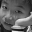

(900, 32, 32, 1)


In [ ]:
from utils import show_array
import numpy as np

import keras
from keras.models import model_from_json
model1 = model_from_json(open('model.json').read())
model1.load_weights('weights.h5')

X = np.load('X.npy')
class_names = ['Neutral', 'Smiling']
img = X[-7]
show_array(255 * img)

print(X[100:1000].shape)

probabilities = model1.predict(X[100:1000])

Using TensorFlow backend.







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








0 : conv2d_1_input, <keras.engine.input_layer.InputLayer object at 0x1c3df8d5d0>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x1c3df8d650>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x1c3e330190>
3 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x1c3dfc6210>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x1c3dfb6f90>
5 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x1c3e3407d0>
6 : max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x1c3dfdd810>
7 : flatten_1, <keras.layers.core.Flatten object at 0x1c3dfe7990>
8 : dense_1, <keras.layers.core.Dense object at 0x1c3e0106d0>
9 : dense_1__activation__, <keras.layers.core.Activation object at 0x1c3e340990>
10 : dense_2, <keras.layers.core.Dense object at 0x1c3e01ddd0>
11 : dense_2__activation__, <keras.layers.core.Activation object at 0x1c3e340a10>


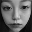

Female


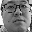

Male


In [1]:
#coreml模型
from utils import show_array
import numpy as np
import PIL.Image
import IPython.display

import keras
from keras.models import model_from_json
model = model_from_json(open('gender_model.json').read())
model.load_weights('gender_weights.h5')

from keras.models import load_model
import coremltools

import coremltools

coreml_model = coremltools.converters.keras.convert(model,input_names='data', image_input_names='data',output_names='outTensor')
coreml_model.save('gender.mlmodel')

# X = np.load('X.npy')
# Y = np.load('Y.npy')
class_names = ['Female', 'Male']
# img = X[-8]
# show_array(255 * img)

#check female
# raw_img = 255*img
# raw_img = np.squeeze(raw_img)
# raw_img = np.uint8(np.clip(raw_img, 0, 255))
# img = PIL.Image.fromarray(raw_img)
img = PIL.Image.open('../dataset/Gender/cropImage/Female/b12_23.jpg')
newsize = (32, 32) 
img = img.resize(newsize) 
display(img)

mlmodel = coremltools.models.MLModel('gender.mlmodel')
out = mlmodel.predict({'data': img})
ret = out['outTensor']
print class_names[np.argmax(ret)]

#check male
img = PIL.Image.open('../dataset/Gender/testdata/yl.jpg').convert('L')
newsize = (32, 32) 
img = img.resize(newsize)
display(img)

mlmodel = coremltools.models.MLModel('gender.mlmodel')
out = mlmodel.predict({'data': img})
ret = out['outTensor']
print class_names[np.argmax(ret)]